<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/03_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports and drive mount

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import scipy.signal
import pandas as pd
from numpy.matrixlib.defmatrix import matrix


#Writing and loading variables
import pickle

#RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "RF_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/RF/"  #change to /RF to actually overwrite stored models

  # Save the variables to a file
  with open(os.path.join(directory, model_filename), "wb") as f:
      pickle.dump((model), f)
  return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 4.1 Decission Tree model Raw
def get_RF_rawdata(n):
  # Create a decision tree classifier
  raw_forest = RandomForestClassifier(min_samples_split = 8,
                                min_samples_leaf = 1,
                                max_depth = 15,
                                n_estimators = 130,
                                bootstrap = False
                                )

  # Fit the model
  raw_forest.fit(X_train,y_train)

  # Evaluate the accuracy of the model
  y_pred = raw_forest.predict(X_val)
  plot_class_acc(y_val, y_pred, "Validation data")

  #Evaluate overfitting by printing training data results
  y_pred = raw_forest.predict(X_train)
  plot_class_acc(y_train, y_pred, "Train data")

  y_pred = raw_forest.predict(X_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")

  save_model(raw_forest,"raw",n)
  return  metrics, matrix

Fitting 5 folds for each of 100 candidates, totalling 500 fits


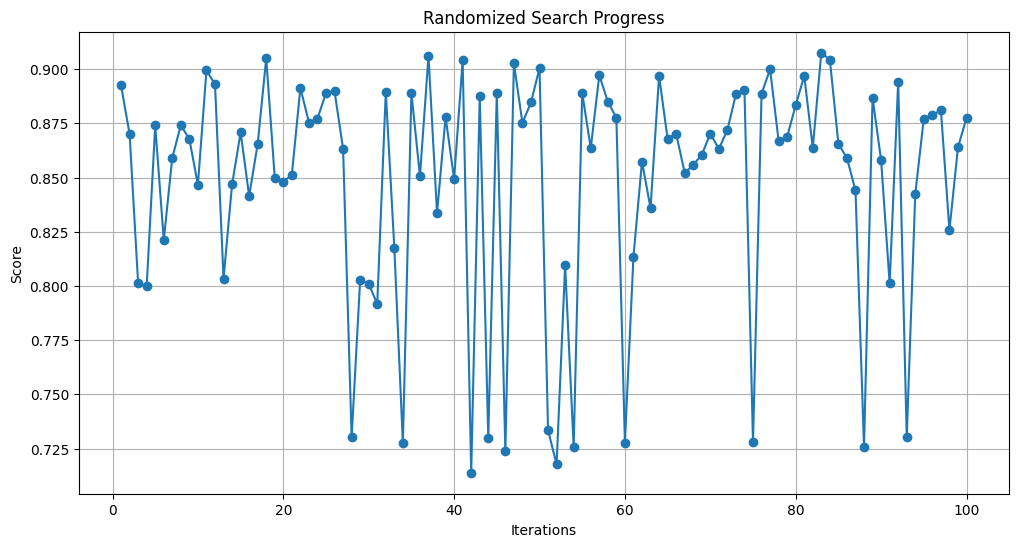

Best Parameters for PSD: {'n_estimators': 130, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': False}
Best Score for PSD: 0.907586566299942


In [ ]:
#@title RF RANDOM parameter tuner:


from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': np.arange(10, 201, 10),
    'max_depth': [None] + list(np.arange(5, 20, 2)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]
}

# Create a Random Forest model
rf_model = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all available cores)
    random_state=42
)

X_train, X_test, X_val, y_train, y_test, y_val = dataload('data1.pkl')
psd_train, psd_val, psd_test = get_psd()
# Perform the randomized search
random_search.fit(psd_train, y_train)

# Plotting the progress
results = random_search.cv_results_
plt.figure(figsize=(12, 6))
plt.title("Randomized Search Progress")
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.grid(True)

# Plot the scores for each iteration
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], marker='o')

plt.show()

# Print the best parameters and score
print("Best Parameters for PSD:", random_search.best_params_)
print("Best Score for PSD:", random_search.best_score_)


In [ ]:
######################################################################### RAW DATA

# Create a Random Forest model
rf_model_mfcc = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model_mfcc,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all available cores)
    random_state=42
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters for PSD:", random_search.best_params_)
print("Best Score for PSD:", random_search.best_score_)

############################################################################ MFCC

# Create a Random Forest model
rf_model_psd = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model_psd,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all available cores)
    random_state=42
)


mfcc_train, mfcc_val, mfcc_test = get_mfcc()
# Perform the randomized search
random_search.fit(mfcc_train, y_train)

# Print the best parameters and score
print("Best Parameters for PSD:", random_search.best_params_)
print("Best Score for PSD:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for PSD: {'n_estimators': 130, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': False}
Best Score for PSD: 0.4074959053685168
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for PSD: {'n_estimators': 110, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': False}
Best Score for PSD: 0.9405110430970304


In [ ]:
#@title 4.2 Random Forest model MFCC

def get_RF_mfcc(n):
# Create a decision tree classifier
  rforest_mfcc = RandomForestClassifier(min_samples_split = 7,
                                min_samples_leaf = 4,
                                max_depth = None,
                                n_estimators = 110,
                                bootstrap = False
                                )

  # Fit the model to the training data
  rforest_mfcc.fit(mfcc_train, y_train)

  # Evaluate the accuracy of the model
  y_pred = rforest_mfcc.predict(mfcc_val)
  x = plot_class_acc(y_val, y_pred, "Validation data")

  #Evaluate overfitting by printing training data results
  y_pred = rforest_mfcc.predict(mfcc_train)
  x = plot_class_acc(y_train, y_pred, "Train data")

  #Evaluate overfitting by printing training data results
  y_pred = rforest_mfcc.predict(mfcc_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")
  save_model(rforest_mfcc,"mfcc",n)
  return metrics, matrix

In [ ]:
#@title 4.3 Random Forest model PSD

def get_RF_psd(n):
  # Create a decision tree classifier
  rforest_psd = RandomForestClassifier( min_samples_leaf = 1,
                                        max_depth = 15,
                                        n_estimators = 130,
                                        # min_impurity_decrease = 0.002
                                        min_samples_split = 8,
                                        bootstrap = False
                                )
  # Fit the model to the training data
  rforest_psd.fit(psd_train, y_train)

  # Evaluate the accuracy of the model
  y_pred = rforest_psd.predict(psd_val)
  accuracy = accuracy_score(y_val, y_pred)
  x = plot_class_acc(y_val, y_pred, "Validation data")

  #Evaluate overfitting by printing training data results
  y_pred =rforest_psd.predict(psd_train)
  x = plot_class_acc(y_train, y_pred, "Train data")

  #Evaluate overfitting by printing training data results
  y_pred = rforest_psd.predict(psd_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")

  save_model(rforest_psd,"psd",n)
  return metrics, matrix

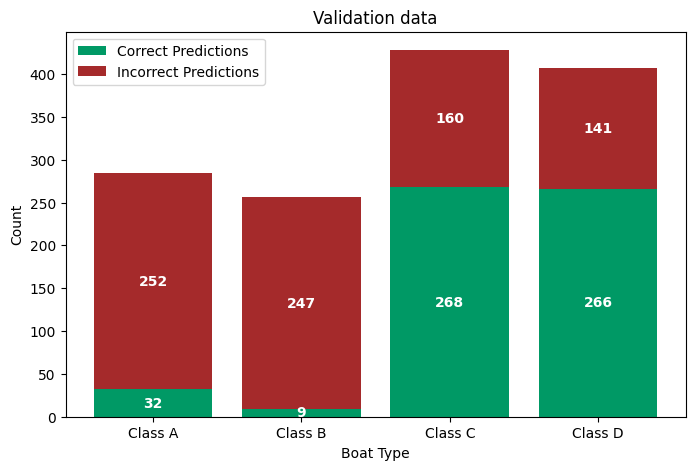

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       32        2       90      160
1        3        9      162       82
2        5        3      268      152
3        2        4      135      266

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.762   0.113     0.196     0.418
1  Class 1      0.500   0.035     0.066     0.418
2  Class 2      0.409   0.626     0.495     0.418
3  Class 3      0.403   0.654     0.499     0.418


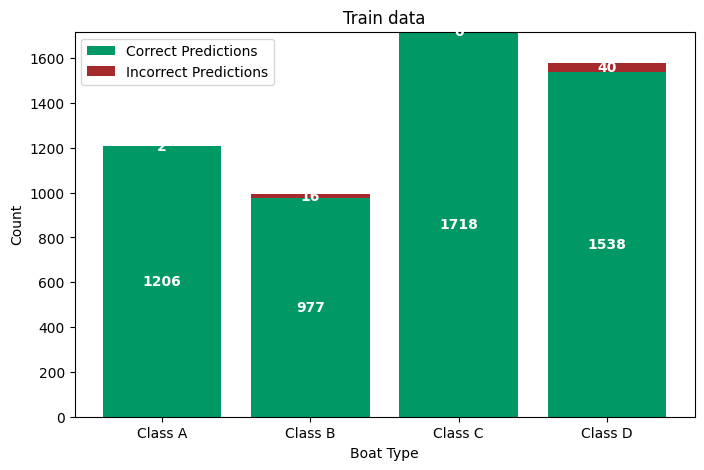

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1206        0        2        0
1        0      977       16        0
2        0        0     1718        0
3        0        0       40     1538

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   0.998     0.999     0.989
1  Class 1      1.000   0.984     0.992     0.989
2  Class 2      0.967   1.000     0.983     0.989
3  Class 3      1.000   0.975     0.987     0.989


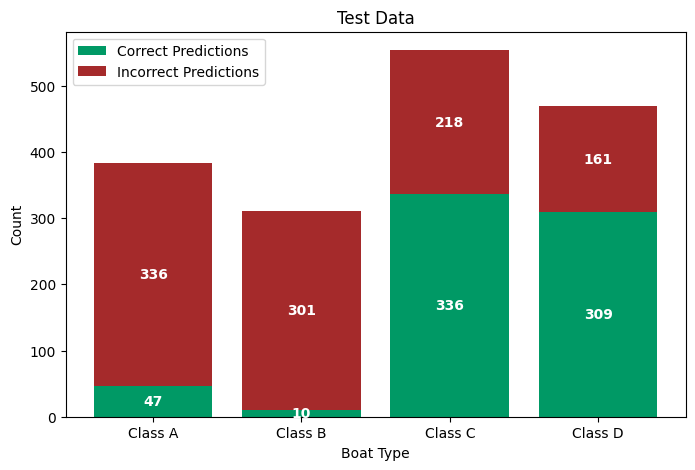

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       47        9      143      184
1        1       10      194      106
2        4        7      336      207
3        3        1      157      309

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.855   0.123     0.215     0.409
1  Class 1      0.370   0.032     0.059     0.409
2  Class 2      0.405   0.606     0.486     0.409
3  Class 3      0.383   0.657     0.484     0.409


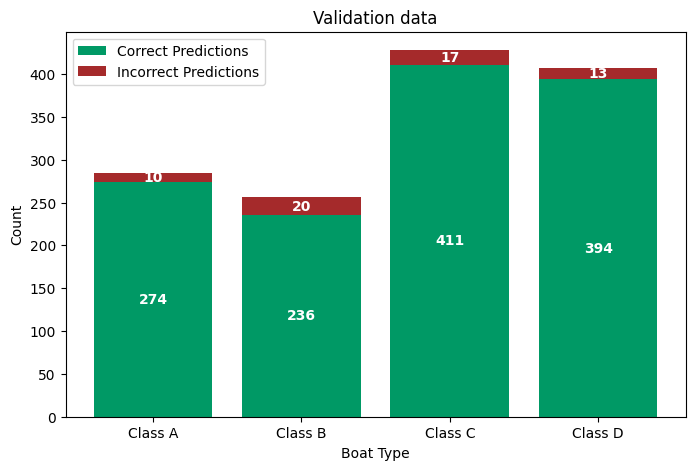

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      274        4        4        2
1        3      236       16        1
2        4        5      411        8
3        1        2       10      394

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.972   0.965     0.968     0.956
1  Class 1      0.955   0.922     0.938     0.956
2  Class 2      0.932   0.960     0.946     0.956
3  Class 3      0.973   0.968     0.970     0.956


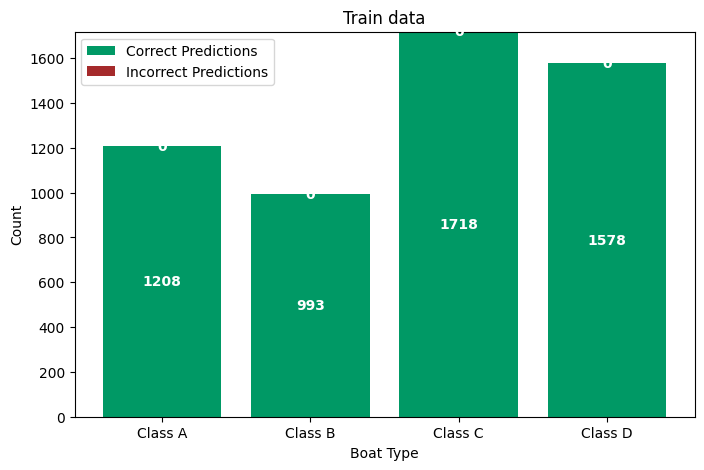

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1208        0        0        0
1        0      993        0        0
2        0        0     1718        0
3        0        0        0     1578

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


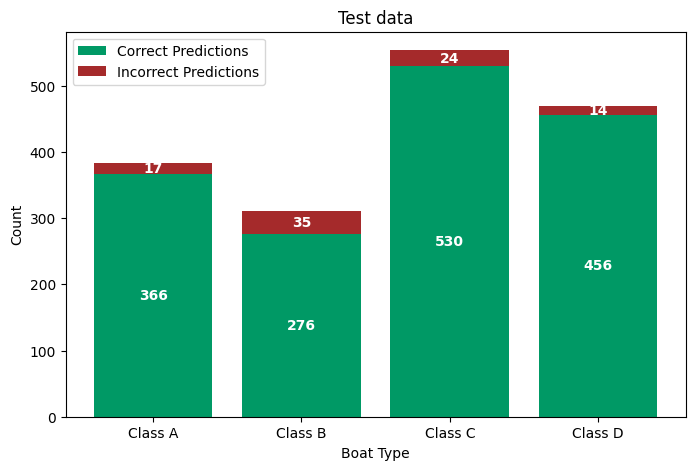

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      366        8        3        6
1        7      276       25        3
2        9        7      530        8
3        1        2       11      456

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.956   0.956     0.956     0.948
1  Class 1      0.942   0.887     0.914     0.948
2  Class 2      0.931   0.957     0.944     0.948
3  Class 3      0.964   0.970     0.967     0.948


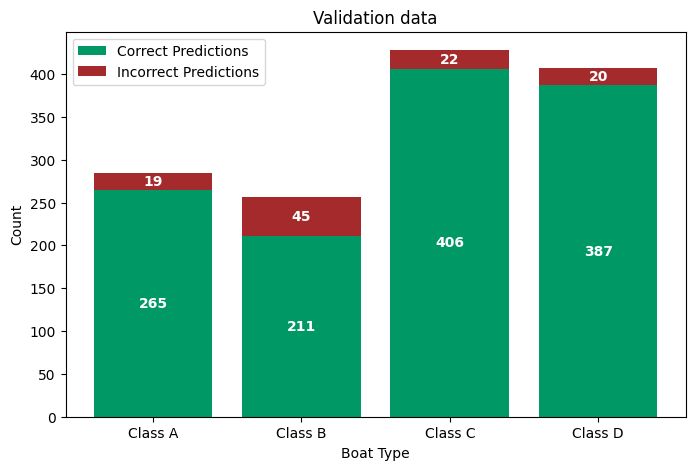

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      265        3       11        5
1       14      211       22        9
2        8        4      406       10
3        4        2       14      387

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.911   0.933     0.922     0.923
1  Class 1      0.959   0.824     0.887     0.923
2  Class 2      0.896   0.949     0.922     0.923
3  Class 3      0.942   0.951     0.946     0.923


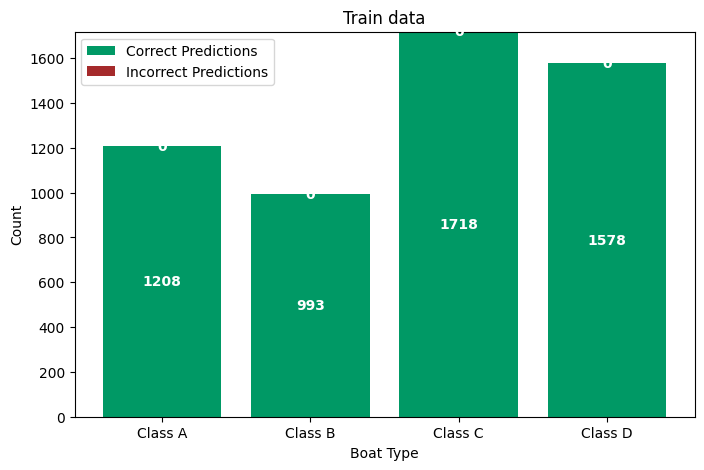

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1208        0        0        0
1        0      993        0        0
2        0        0     1718        0
3        0        0        0     1578

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


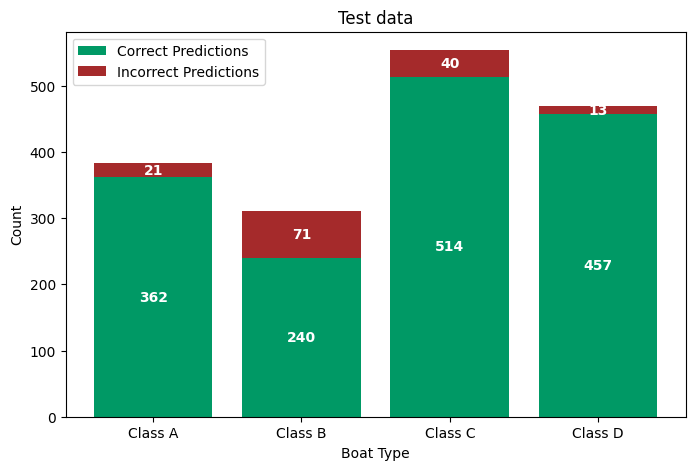

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      362        4        9        8
1       17      240       38       16
2       15        3      514       22
3        2        1       10      457

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.914   0.945     0.929     0.916
1  Class 1      0.968   0.772     0.859     0.916
2  Class 2      0.900   0.928     0.914     0.916
3  Class 3      0.909   0.972     0.939     0.916


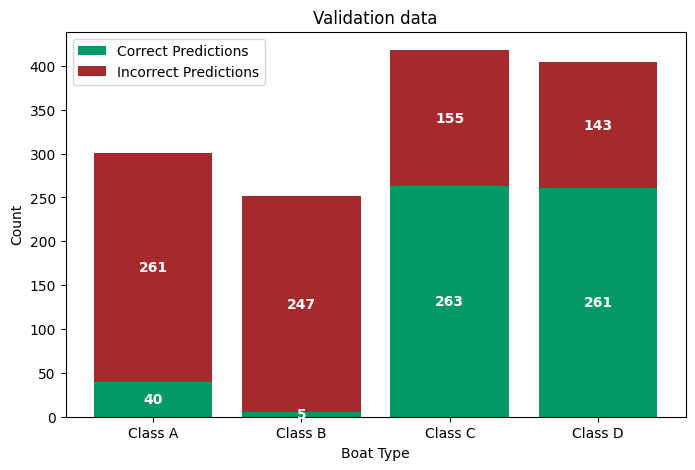

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       40        3      100      158
1        0        5      175       72
2        4        6      263      145
3        2        4      137      261

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.870   0.133     0.231     0.414
1  Class 1      0.278   0.020     0.037     0.414
2  Class 2      0.390   0.629     0.481     0.414
3  Class 3      0.410   0.646     0.502     0.414


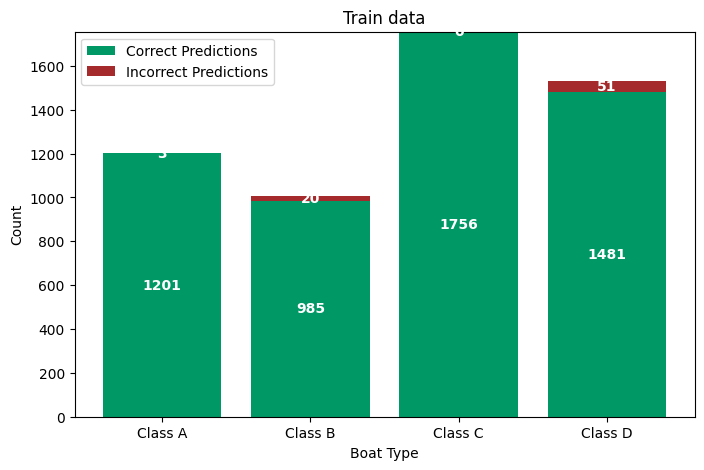

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1201        0        3        0
1        0      985       20        0
2        0        0     1756        0
3        0        0       51     1481

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   0.998     0.999     0.987
1  Class 1      1.000   0.980     0.990     0.987
2  Class 2      0.960   1.000     0.979     0.987
3  Class 3      1.000   0.967     0.983     0.987


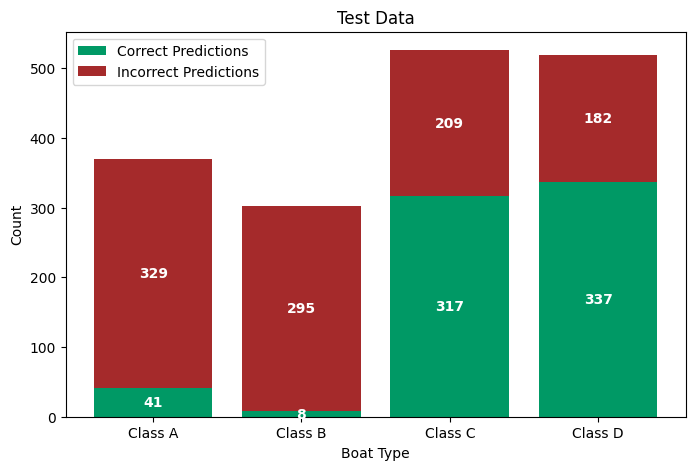

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       41        4      160      165
1        0        8      204       91
2        7        9      317      193
3        5        4      173      337

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.774   0.111     0.194     0.409
1  Class 1      0.320   0.026     0.049     0.409
2  Class 2      0.371   0.603     0.459     0.409
3  Class 3      0.429   0.649     0.516     0.409


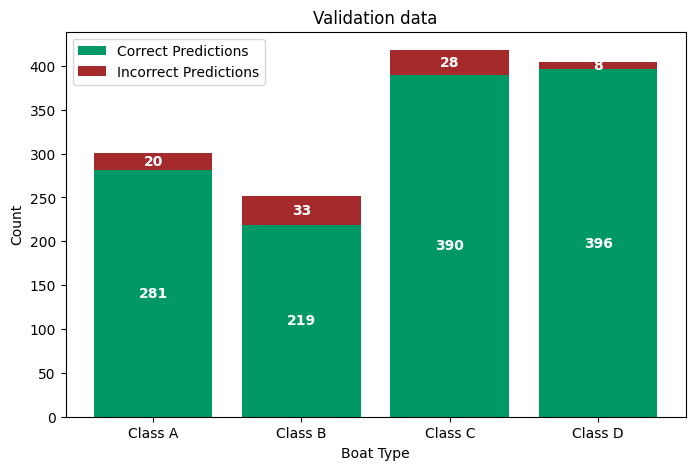

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      281        2       13        5
1        4      219       25        4
2        7       10      390       11
3        1        0        7      396

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.959   0.934     0.946     0.935
1  Class 1      0.948   0.869     0.907     0.935
2  Class 2      0.897   0.933     0.914     0.935
3  Class 3      0.952   0.980     0.966     0.935


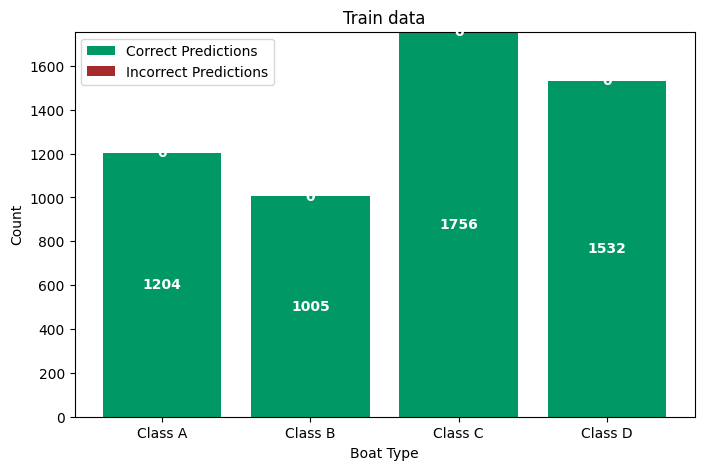

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1204        0        0        0
1        0     1005        0        0
2        0        0     1756        0
3        0        0        0     1532

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


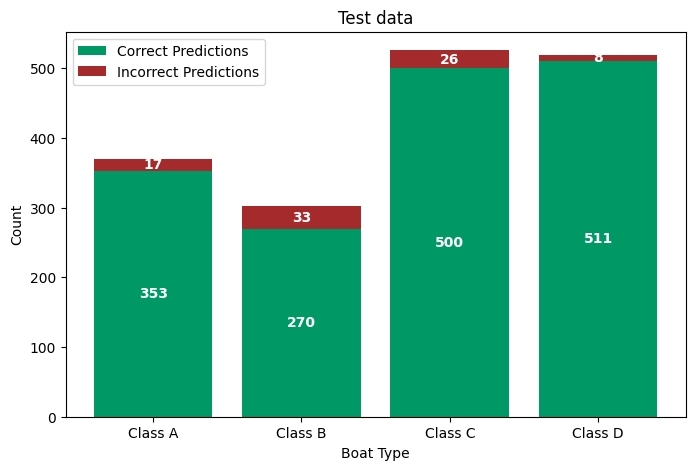

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      353        3       10        4
1        7      270       25        1
2        9       10      500        7
3        2        0        6      511

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.951   0.954     0.953     0.951
1  Class 1      0.954   0.891     0.922     0.951
2  Class 2      0.924   0.951     0.937     0.951
3  Class 3      0.977   0.985     0.981     0.951


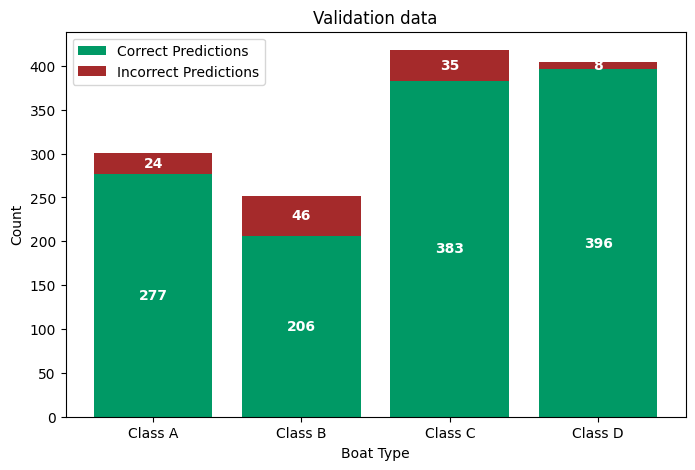

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      277        0       16        8
1       11      206       27        8
2       15        4      383       16
3        0        0        8      396

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.914   0.920     0.917     0.918
1  Class 1      0.981   0.817     0.892     0.918
2  Class 2      0.882   0.916     0.899     0.918
3  Class 3      0.925   0.980     0.952     0.918


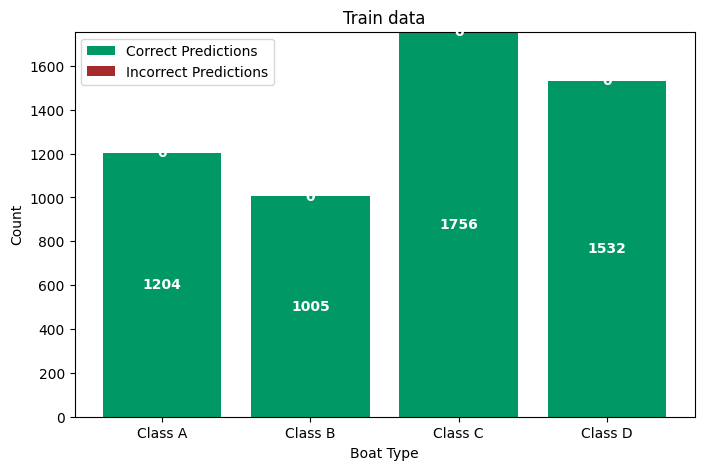

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1204        0        0        0
1        0     1005        0        0
2        0        0     1756        0
3        0        0        0     1532

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


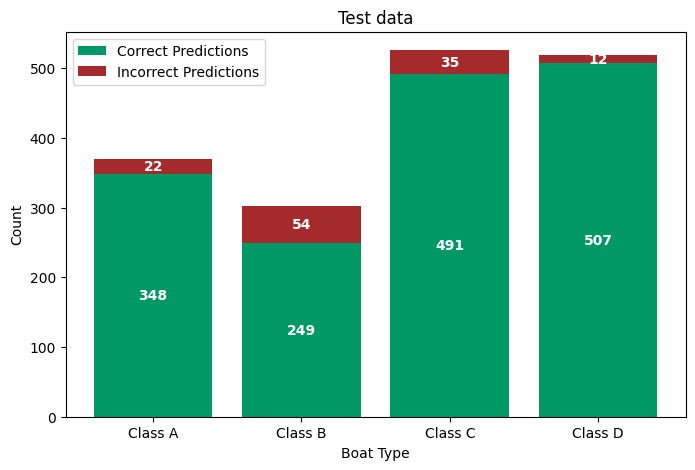

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      348        1       10       11
1       14      249       30       10
2       17        4      491       14
3        1        1       10      507

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.916   0.941     0.928     0.928
1  Class 1      0.976   0.822     0.892     0.928
2  Class 2      0.908   0.933     0.920     0.928
3  Class 3      0.935   0.977     0.956     0.928


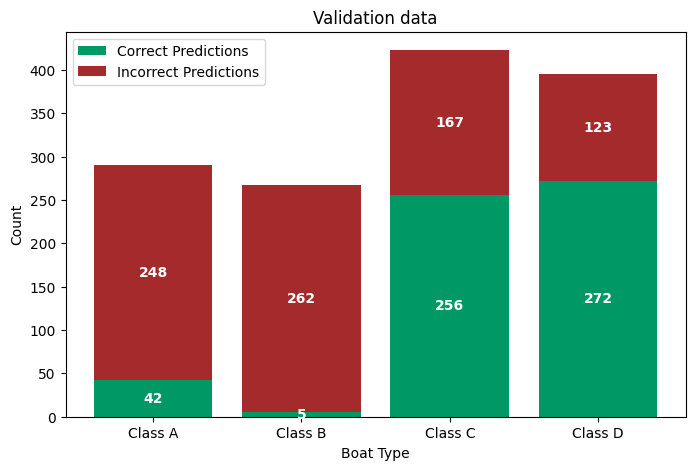

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       42        2      107      139
1        0        5      176       86
2        4       12      256      151
3        4        5      114      272

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.840   0.145     0.247     0.418
1  Class 1      0.208   0.019     0.034     0.418
2  Class 2      0.392   0.605     0.476     0.418
3  Class 3      0.420   0.689     0.522     0.418


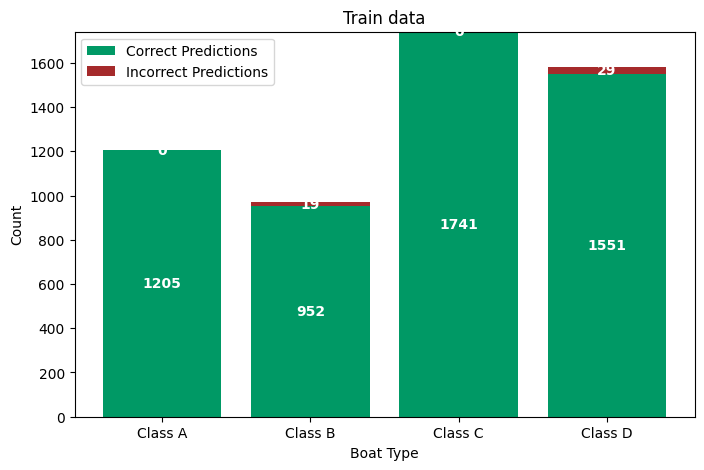

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1205        0        0        0
1        0      952       19        0
2        0        0     1741        0
3        0        0       29     1551

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     0.991
1  Class 1      1.000   0.980     0.990     0.991
2  Class 2      0.973   1.000     0.986     0.991
3  Class 3      1.000   0.982     0.991     0.991


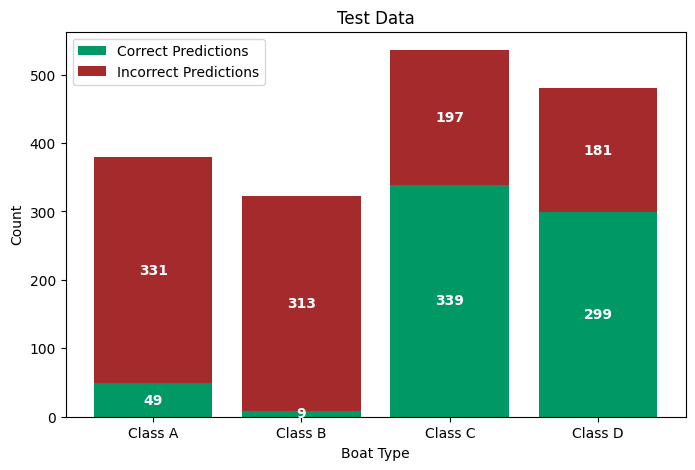

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       49        1      142      188
1        1        9      194      118
2        5        4      339      188
3        7        7      167      299

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.790   0.129     0.222     0.405
1  Class 1      0.429   0.028     0.052     0.405
2  Class 2      0.403   0.632     0.492     0.405
3  Class 3      0.377   0.623     0.470     0.405


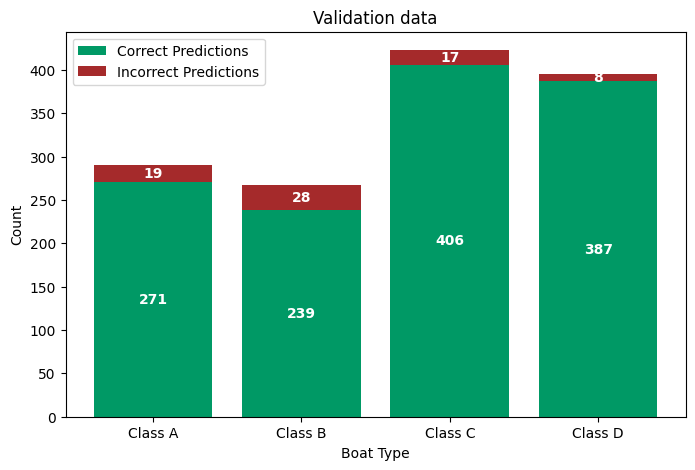

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      271        7        5        7
1        4      239       22        2
2        5        6      406        6
3        0        1        7      387

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.968   0.934     0.951     0.948
1  Class 1      0.945   0.895     0.919     0.948
2  Class 2      0.923   0.960     0.941     0.948
3  Class 3      0.963   0.980     0.971     0.948


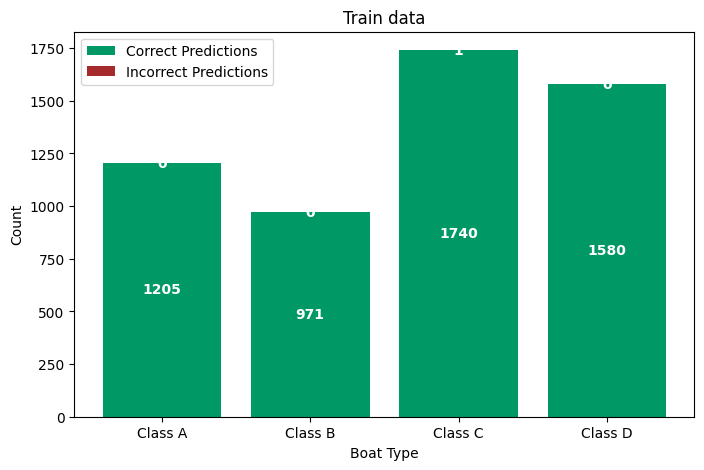

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1205        0        0        0
1        0      971        0        0
2        0        0     1740        1
3        0        0        0     1580

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   0.999     1.000     1.000
3  Class 3      0.999   1.000     1.000     1.000


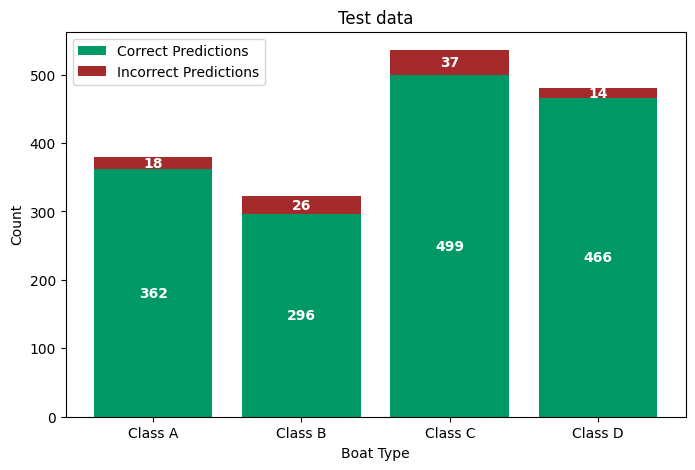

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      362       11        5        2
1        4      296       19        3
2       12       12      499       13
3        0        1       13      466

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.958   0.953     0.955     0.945
1  Class 1      0.925   0.919     0.922     0.945
2  Class 2      0.931   0.931     0.931     0.945
3  Class 3      0.963   0.971     0.967     0.945


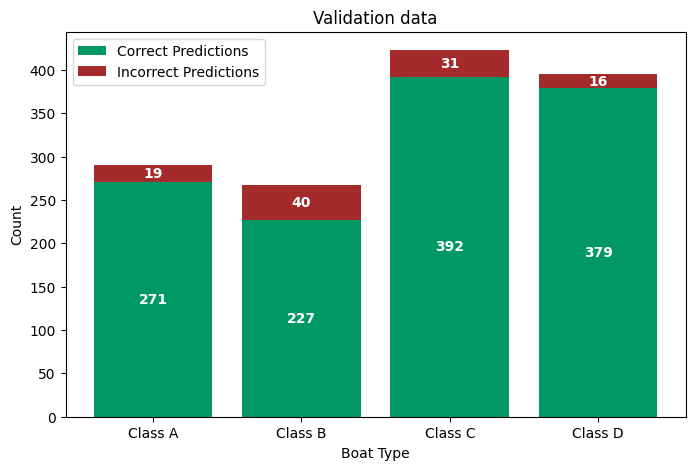

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      271        2       10        7
1        8      227       24        8
2       10        1      392       20
3        0        4       12      379

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.938   0.934     0.936     0.923
1  Class 1      0.970   0.850     0.906     0.923
2  Class 2      0.895   0.927     0.911     0.923
3  Class 3      0.915   0.959     0.937     0.923


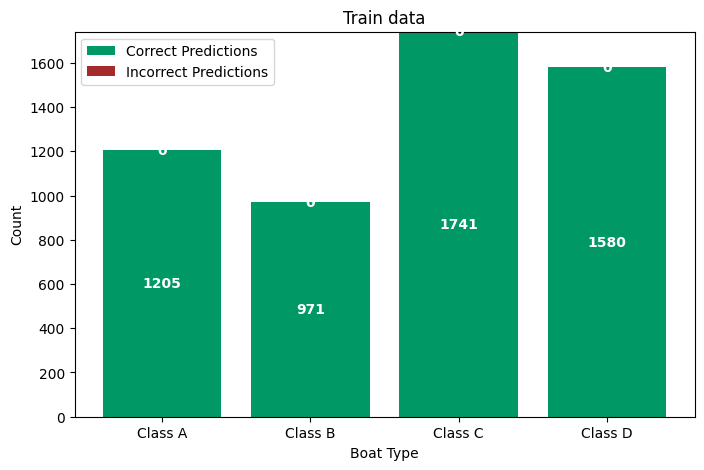

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1205        0        0        0
1        0      971        0        0
2        0        0     1741        0
3        0        0        0     1580

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


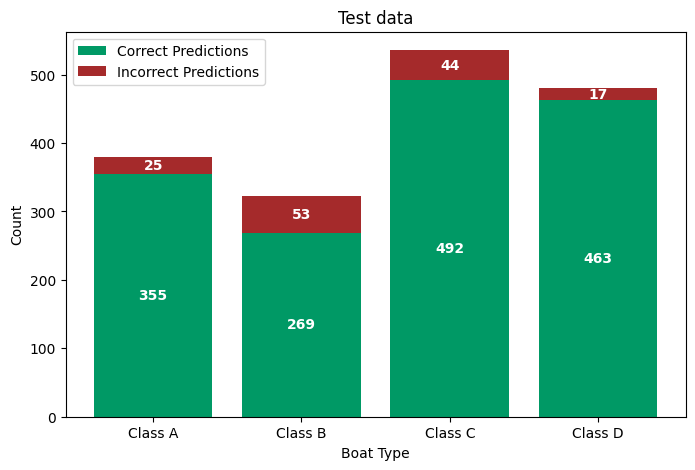

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      355        2       14        9
1        7      269       26       20
2       16        5      492       23
3        0        1       16      463

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.939   0.934     0.937     0.919
1  Class 1      0.971   0.835     0.898     0.919
2  Class 2      0.898   0.918     0.908     0.919
3  Class 3      0.899   0.965     0.931     0.919


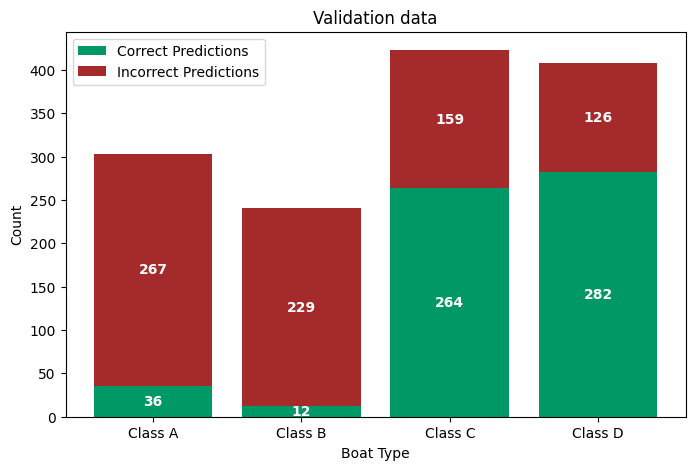

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       36        3       96      168
1        0       12      142       87
2        3        6      264      150
3        2        4      120      282

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.878   0.119     0.209     0.432
1  Class 1      0.480   0.050     0.090     0.432
2  Class 2      0.424   0.624     0.505     0.432
3  Class 3      0.410   0.691     0.515     0.432


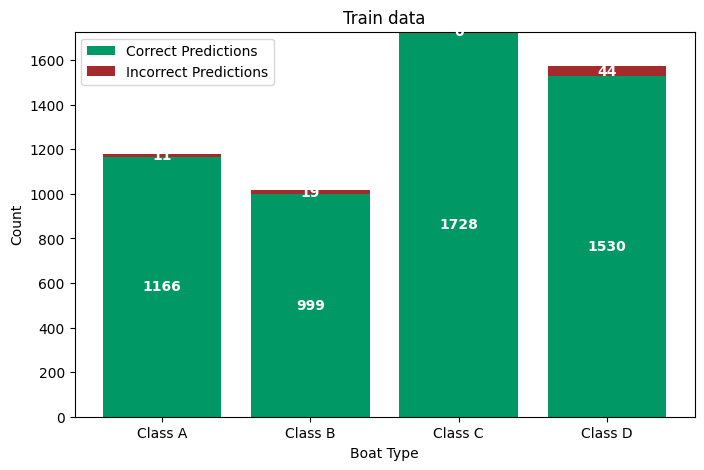

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1166        0       11        0
1        0      999       19        0
2        0        0     1728        0
3        0        0       44     1530

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   0.991     0.995     0.987
1  Class 1      1.000   0.981     0.991     0.987
2  Class 2      0.959   1.000     0.979     0.987
3  Class 3      1.000   0.972     0.986     0.987


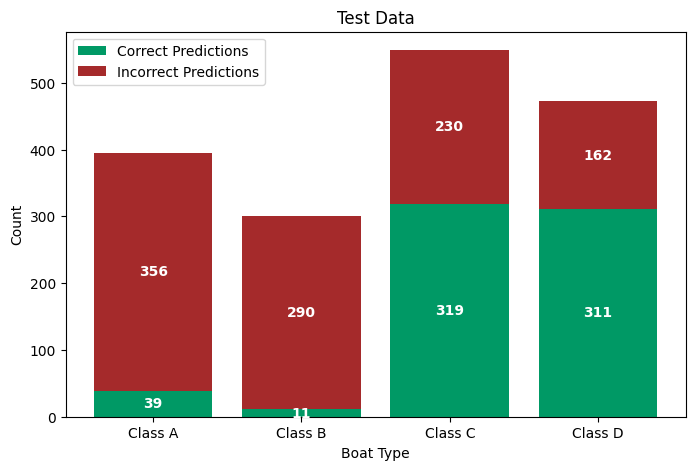

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       39        5      146      205
1        0       11      184      106
2        5        9      319      216
3        3        4      155      311

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.830   0.099     0.176     0.396
1  Class 1      0.379   0.037     0.067     0.396
2  Class 2      0.397   0.581     0.472     0.396
3  Class 3      0.371   0.658     0.474     0.396


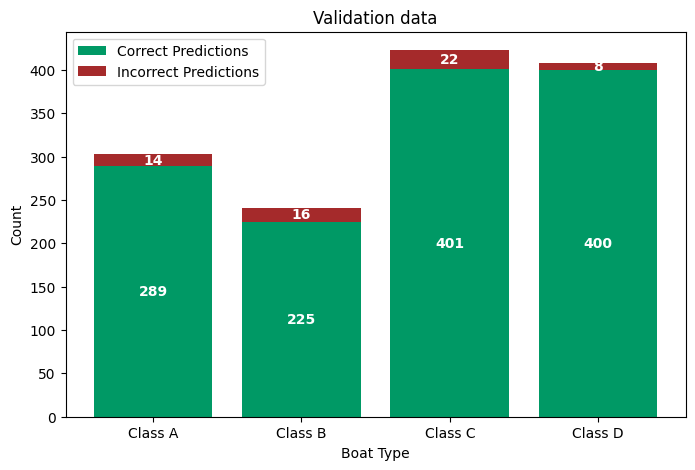

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      289        5        5        4
1        2      225       14        0
2        4        8      401       10
3        1        0        7      400

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.976   0.954     0.965     0.956
1  Class 1      0.945   0.934     0.939     0.956
2  Class 2      0.939   0.948     0.944     0.956
3  Class 3      0.966   0.980     0.973     0.956


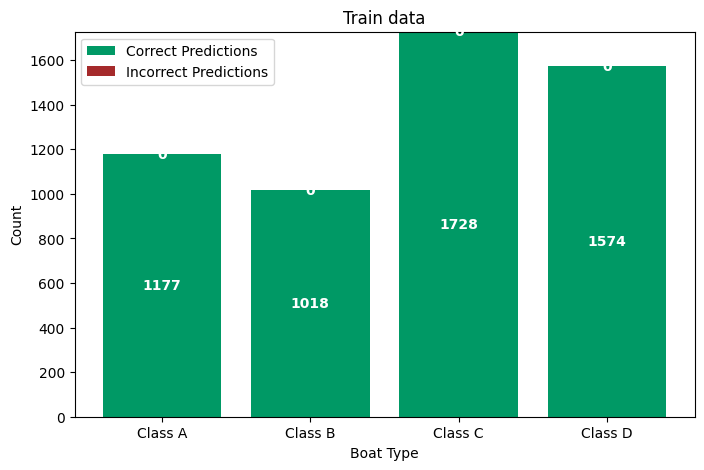

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1177        0        0        0
1        0     1018        0        0
2        0        0     1728        0
3        0        0        0     1574

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


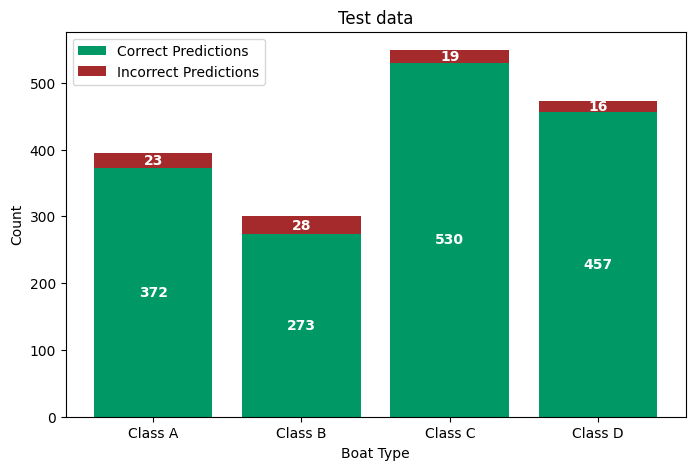

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      372        7        9        7
1        4      273       23        1
2        4        9      530        6
3        0        1       15      457

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.979   0.942     0.960     0.950
1  Class 1      0.941   0.907     0.924     0.950
2  Class 2      0.919   0.965     0.941     0.950
3  Class 3      0.970   0.966     0.968     0.950


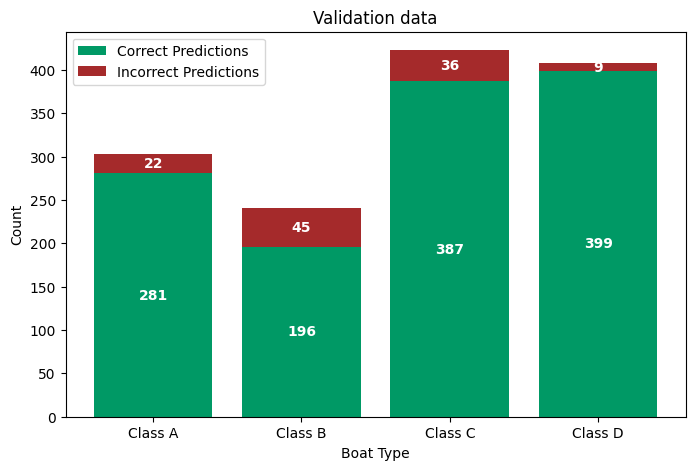

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      281        1        8       13
1        7      196       30        8
2       11        4      387       21
3        2        1        6      399

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.934   0.927     0.930     0.919
1  Class 1      0.970   0.813     0.885     0.919
2  Class 2      0.898   0.915     0.906     0.919
3  Class 3      0.905   0.978     0.940     0.919


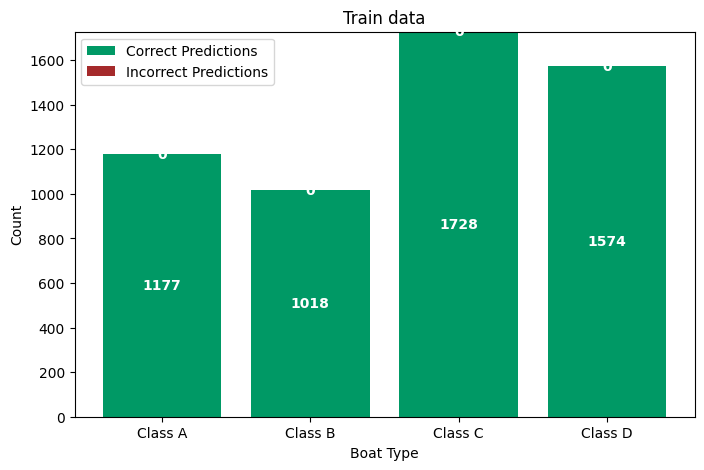

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1177        0        0        0
1        0     1018        0        0
2        0        0     1728        0
3        0        0        0     1574

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


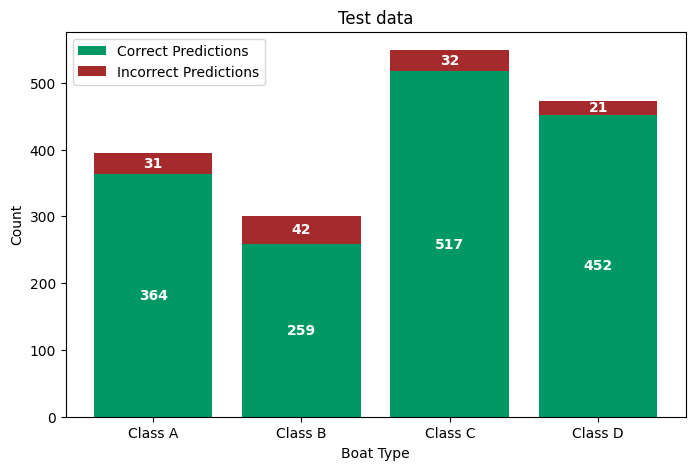

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      364        0       12       19
1        3      259       30        9
2        9        1      517       22
3        1        2       18      452

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.966   0.922     0.943     0.927
1  Class 1      0.989   0.860     0.920     0.927
2  Class 2      0.896   0.942     0.918     0.927
3  Class 3      0.900   0.956     0.927     0.927


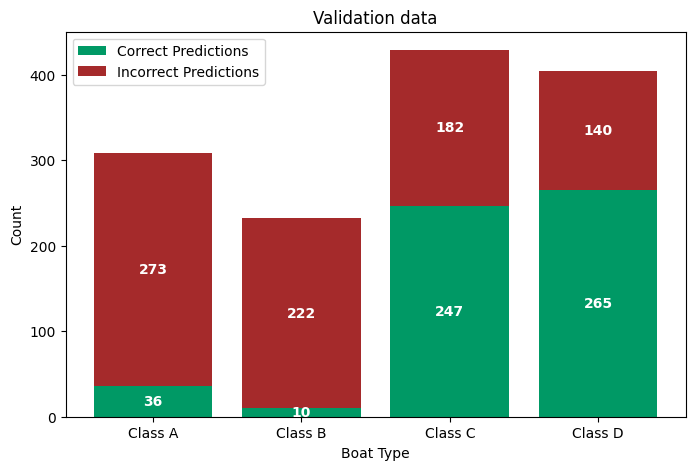

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       36        4      120      149
1        0       10      151       71
2        3        8      247      171
3        2        8      130      265

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.878   0.117     0.206     0.406
1  Class 1      0.333   0.043     0.076     0.406
2  Class 2      0.381   0.576     0.459     0.406
3  Class 3      0.404   0.654     0.500     0.406


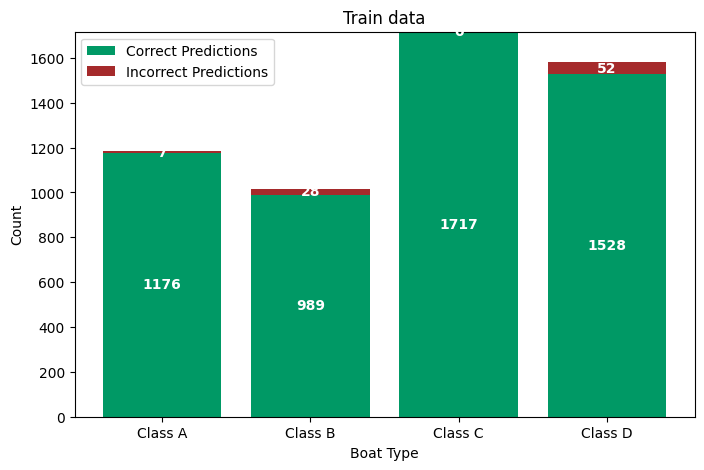

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1176        0        7        0
1        0      989       28        0
2        0        0     1717        0
3        0        0       52     1528

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   0.994     0.997     0.984
1  Class 1      1.000   0.972     0.986     0.984
2  Class 2      0.952   1.000     0.975     0.984
3  Class 3      1.000   0.967     0.983     0.984


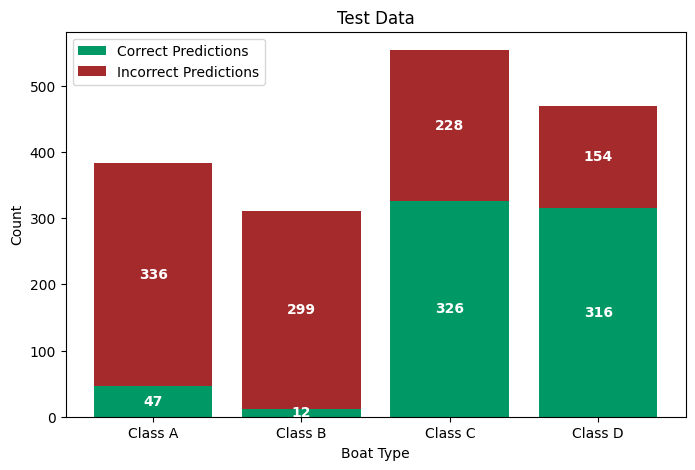

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       47        2      139      195
1        1       12      207       91
2        0        8      326      220
3        4        8      142      316

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.904   0.123     0.216     0.408
1  Class 1      0.400   0.039     0.070     0.408
2  Class 2      0.400   0.588     0.477     0.408
3  Class 3      0.384   0.672     0.489     0.408


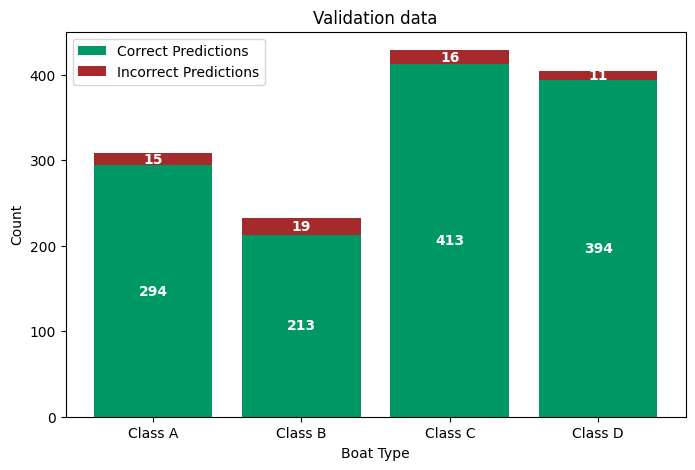

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      294        7        7        1
1        3      213       16        0
2        6        7      413        3
3        1        0       10      394

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.967   0.951     0.959     0.956
1  Class 1      0.938   0.918     0.928     0.956
2  Class 2      0.926   0.963     0.944     0.956
3  Class 3      0.990   0.973     0.981     0.956


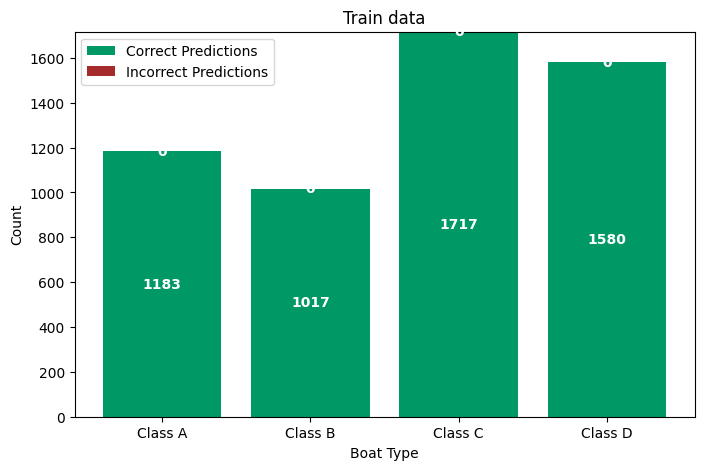

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1183        0        0        0
1        0     1017        0        0
2        0        0     1717        0
3        0        0        0     1580

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


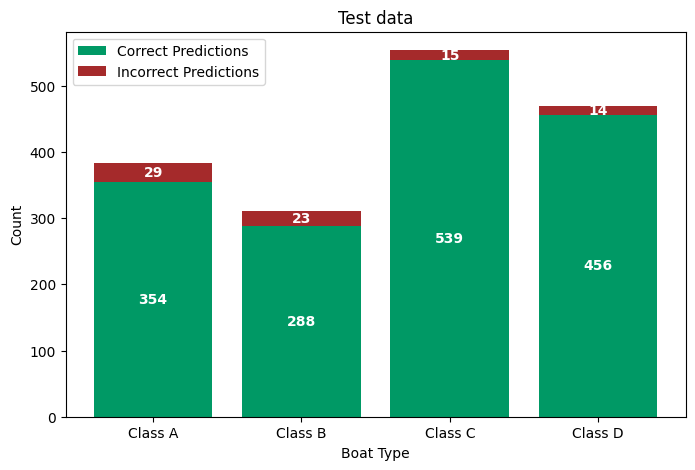

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      354       11       12        6
1        3      288       18        2
2        3        8      539        4
3        2        0       12      456

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.978   0.924     0.950     0.953
1  Class 1      0.938   0.926     0.932     0.953
2  Class 2      0.928   0.973     0.950     0.953
3  Class 3      0.974   0.970     0.972     0.953


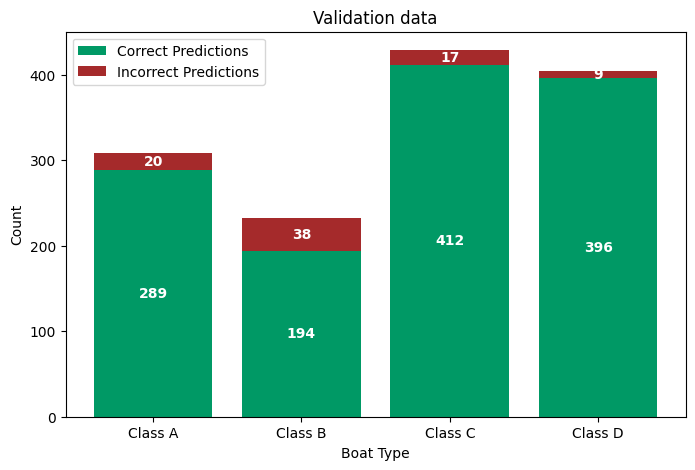

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      289        1       11        8
1        8      194       23        7
2        5        2      412       10
3        0        0        9      396

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.957   0.935     0.946     0.939
1  Class 1      0.985   0.836     0.904     0.939
2  Class 2      0.905   0.960     0.932     0.939
3  Class 3      0.941   0.978     0.959     0.939


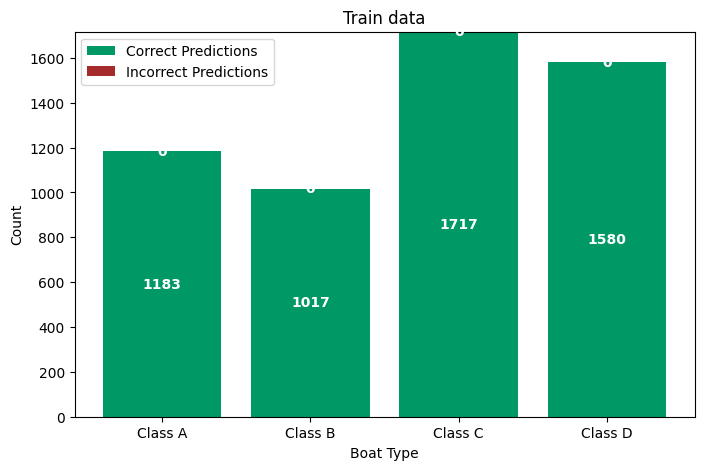

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1183        0        0        0
1        0     1017        0        0
2        0        0     1717        0
3        0        0        0     1580

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      1.000   1.000     1.000     1.000
1  Class 1      1.000   1.000     1.000     1.000
2  Class 2      1.000   1.000     1.000     1.000
3  Class 3      1.000   1.000     1.000     1.000


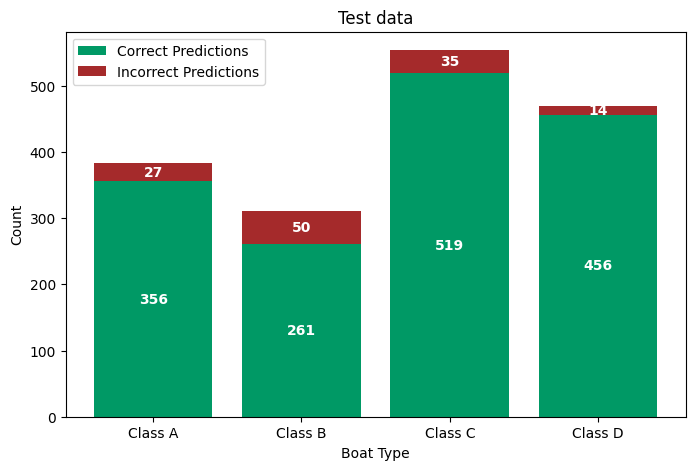

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      356        2       14       11
1       12      261       32        6
2       12        4      519       19
3        0        1       13      456

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.937   0.930     0.933     0.927
1  Class 1      0.974   0.839     0.902     0.927
2  Class 2      0.898   0.937     0.917     0.927
3  Class 3      0.927   0.970     0.948     0.927


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 1
mfcc = 1
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)

  if raw == 1:
  # Get raw data
    metrics, matrix = get_RF_rawdata(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()
    metrics1, matrix1 = get_RF_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    metrics2, matrix2 = get_RF_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd)

Class A                           & 0.932                               & (0.018)     & 0.933                         & (0.008)         & 0.932                  & (0.005)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & \highest{0.974}                               & (0.004)      & 0.828                         & (0.029)         & 0.895                  & (0.018)                  \\Class C                           & 0.904                               & (0.009)      & 0.933                        & (0.012)         & 0.918                  & (0.004)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & 0.916                              & (0.015)      & \highest{0.97}                         & (0.005)         & \highest{0.942}                  & (0.01)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \te

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_psd)


x y C


NameError: ignored